# Wide Quantum Circuit Learning

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize

In [2]:
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

In [3]:
from tqdm import tqdm
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder

In [24]:
ENCODING_SIZE = 10
NUM_QUBITS =4
NUM_CLASSES= 10
# NUM_LAYERS specifies how many times the circuit is run over the qubit wires.
# Should increase runtime by a factor of NUM_LAYERS.
NUM_LAYERS = 3

In [5]:
dev = qml.device("forest.qvm", device="{}q-pyqvm".format(NUM_QUBITS), shots=1000)

In [25]:
from pennylane.ops import RX, RY, CNOT

# x will be a length ENCODING_SIZE vector that represents
# the encoding of a MNIST image
# thetas is of size 2 * NUM_QUBITS
@qml.qnode(dev)
def circuit(x, thetas):
    for i in range(ENCODING_SIZE):
        RX(x[i], wires=i)
    for j in range(NUM_LAYERS):
        for i in range(NUM_QUBITS - 1):
            CNOT(wires=[i, i+1])
        for i in range(NUM_QUBITS):
            RX(thetas[j][i], wires=i)
        for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
            RY(thetas[j][i], wires=(i - NUM_QUBITS))
    return tuple(qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS))


#params: x - input x
#        mask - mapping from range(ENCODING SIZE) to range(4)
#        thetas - learned parameters
#NOTE: Written for NUM_QUBITS = 4
@qml.qnode(dev)
def circuit_tighten(x, mask, thetas):
    for i in range(ENCODING_SIZE):
            if i // NUM_QUBITS % 2 == 0: 
                RX(x[i], wires=i//NUM_QUBITS)
            else:
                RY(x[i], wires=i//NUM_QUBITS)
    for j in range(NUM_LAYERS):
        CNOT(wires=[0, 1])
        CNOT(wires=[1, 3])
        CNOT(wires=[0, 2])
        for i in range(NUM_QUBITS):
            RX(thetas[j][i], wires=i)
        for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
            RY(thetas[j][i], wires=(i - NUM_QUBITS))
    return [qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS)]

def get_mask():
    sub_masks = []
    for i in range(ENCODING_SIZE//NUM_QUBITS + 1):
        sub_masks.append(np.random.permutation(NUM_QUBITS))
    res = np.concatenate(sub_masks).flatten()
    return res.tolist()

In [26]:
# example input
MASK = get_mask()
print(np.mean(circuit_tighten([np.pi/5]*(ENCODING_SIZE), MASK, [[np.pi]*(2 * NUM_QUBITS)]*NUM_LAYERS)))

-0.297


In [27]:
# NOTE: EDITED COST FUNCTION to use bias, and to prevent bias from gaming
#       the cost function.
def cost(X, actual_labels, thetas, bias):
    b = X.shape[0]
    yhats = []
    for i in range(b):
        scores = []
        for j in range(NUM_CLASSES):
            scores.append(np.mean(circuit_tighten(X[i], MASK, thetas[j]) + bias[j]))
        yhats.append(scores)
    st = np.stack(yhats)
    actual_class_vals = st[range(b), actual_labels]
    shifted = st - np.max(st, axis=1)[:, np.newaxis]
    the_sum = np.log(np.sum(np.exp(shifted), axis=1)) 
    # Return loss + regularization term on bias
    return np.mean(-actual_class_vals + the_sum + np.max(st, axis=1))

At this point, we have to get our (encoded) images so that we may actually start training

In [28]:
data = MNISTData(batch_size=16)
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [29]:
load_from_stem = "./autoencoder_models/1558731906/"
load_model_from = os.path.join(load_from_stem, "ae.pt")
load_layers_from = os.path.join(load_from_stem, "layer_sizes.pkl")

In [30]:
with open(load_layers_from, 'rb') as f:
    layer_sizes = pickle.load(f)
layer_sizes = layer_sizes[1:]
ae = AutoEncoder(layer_sizes)
ae.load_state_dict(torch.load(load_model_from))
encoder = ae.encoder
for child in encoder.children():
    for param in child.parameters():
        param.requires_grad = False

In [31]:
summary(encoder, input_size=(28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
Total params: 218,058
Trainable params: 0
Non-trainable params: 218,058
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [32]:
thetas = 1/ENCODING_SIZE*np.random.randn(2 * NUM_QUBITS*NUM_LAYERS*NUM_CLASSES)
bias = np.zeros(NUM_CLASSES)
thetas = thetas.reshape(NUM_CLASSES, NUM_LAYERS, 2*NUM_QUBITS)
init_thetas = thetas.copy()
init_bias = bias.copy()
print(thetas)
print(thetas.dtype)
print(bias)

[[[-1.20731023e-01  4.07285284e-02 -8.85442556e-02  9.01983678e-02
    1.61555479e-02 -7.74203616e-02  1.51146497e-03  1.10626695e-01]
  [-6.48990049e-02  9.82117370e-02 -9.84735243e-02  5.55810415e-02
    6.30929809e-02 -4.43116292e-02 -9.04400335e-02  4.06742645e-02]
  [-2.70905264e-02  9.07893037e-03 -5.08690325e-02  1.00358175e-01
   -9.79922864e-02 -7.75361825e-02 -8.85173476e-03 -1.01032775e-01]]

 [[ 3.02127870e-02 -6.36115496e-02 -7.84776500e-02 -2.77604513e-02
   -5.08873039e-03 -2.11696498e-02  6.06756856e-02 -1.35673693e-01]
  [ 2.13402686e-01 -1.19285767e-01 -2.66993267e-01 -1.94103844e-02
   -9.66617512e-02 -1.10677307e-01  4.86831790e-02  1.18458171e-01]
  [ 7.31610204e-02  5.49648653e-02 -9.20878936e-02 -7.87728023e-02
    1.99760946e-02 -1.15589750e-02 -1.26104644e-01  1.72864632e-01]]

 [[-1.10078874e-01  1.41639454e-02  1.15211214e-01  1.33423522e-01
   -3.78850125e-02  8.34844954e-02 -1.14638011e-02 -6.94581044e-02]
  [ 9.34275784e-02  1.14839364e-01  1.11205216e-01 

In [33]:
# this is the transformation that you need to do in order
# to pass it to the encoder. it is (1, -1) since the first number
# is the batch size, which in our case is 1
enums = enumerate(train_loader, 0)
i, data = next(enums)
inputs, labels = data
print(inputs.size())
print(len(labels))
print(encoder(inputs[0].view(1, -1)))
print(encoder(inputs[0].view(1, -1)).size())
print(circuit_tighten(inputs[0].view(1, -1).numpy(), MASK, thetas[0]))

torch.Size([16, 1, 28, 28])
16
tensor([[25.0548,  2.5514,  0.0000, 14.5513, 36.4181, 24.0503, 15.0945, 17.0040,
         10.1558,  0.0000]])
torch.Size([1, 10])
[-0.214 -0.066  0.228 -0.206]


In [34]:
# Using normal qml.grad
X = encoder(inputs.view(len(labels), -1))
print(X.size())
print(labels.size())
print(thetas.shape)
start = time.time()
dcost = qml.grad(cost, argnum=[2, 3])
theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias) 
print(time.time() - start)

torch.Size([16, 10])
torch.Size([16])
(10, 3, 8)
45.53022265434265


In [35]:
def accuracy(thetas, bias, number_batches=2):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader, 0):
        if i == number_batches:
            break
        inputs, labels = data
        inputs = encoder(inputs.view(len(labels), -1)).numpy()
        predicted = []
        for image in inputs:
            scores = []
            for i in range(NUM_CLASSES):
                scores.append(np.mean(circuit_tighten(image, MASK, thetas[i]) + bias[i]))
            predicted.append(np.argmax(scores))
        correct += (np.asarray(predicted) == labels.numpy()).sum()
        total += len(predicted)
        print(predicted)
    return(correct / total)
# have done no training, so should be around 10%
accuracy(thetas, bias)

[3, 1, 1, 1, 1, 9, 3, 1, 2, 0, 5, 8, 3, 3, 1, 9]
[3, 1, 4, 1, 1, 9, 2, 1, 3, 3, 3, 3, 1, 4, 8, 3]


0.0625

In [36]:
# Overfit like crazy on the first 32 examples
overfit = []
for i, data in enumerate(train_loader, 0):
    overfit.append((i, data))
    if i == 2:
        break
etas = [1, 7e-1, 3e-1, 1e-1]
start = time.time()
accuracies = []
losses = []
for eta in etas:
    for epoch in range(5):
        for i, data in overfit:
            print(labels)
            inputs, labels = data
            X = encoder(inputs.view(len(labels), -1))
            dcost = qml.grad(cost, argnum=[2,3])
            theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias)
            loss = cost(X.numpy(), labels.numpy(), thetas, bias)
            losses.append(loss)
            thetas -= eta * theta_grad
            bias -= eta * bias_grad
            acc = accuracy(thetas, bias)
            accuracies.append(acc)
            print("%d batches took %f seconds and has accuracy %f, with train loss %f" % (i + 1, time.time() - start, acc, loss))
            if i == 1:
                break

tensor([7, 1, 1, 6, 0, 5, 7, 4, 2, 5, 2, 1, 6, 9, 2, 6])
[4, 0, 4, 0, 9, 9, 9, 4, 0, 0, 0, 9, 9, 2, 4, 9]
[9, 0, 4, 0, 4, 4, 4, 0, 4, 9, 9, 9, 4, 0, 9, 4]
1 batches took 47.400188 seconds and has accuracy 0.156250, with train loss 2.304617
tensor([0, 9, 0, 6, 9, 2, 8, 2, 0, 4, 6, 4, 7, 9, 4, 5])
[0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 6, 0, 0]
[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0]
2 batches took 93.981563 seconds and has accuracy 0.156250, with train loss 2.312011
tensor([3, 6, 5, 4, 1, 6, 1, 2, 8, 0, 5, 3, 6, 1, 0, 0])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0]
1 batches took 140.756434 seconds and has accuracy 0.156250, with train loss 2.268433
tensor([0, 9, 0, 6, 9, 2, 8, 2, 0, 4, 6, 4, 7, 9, 4, 5])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 batches took 188.572499 seconds and has accuracy 0.156250, with train loss 2.276826
tensor([3, 6, 5, 4, 1, 6, 1, 2, 8, 0, 

2 batches took 1635.954721 seconds and has accuracy 0.156250, with train loss 2.164291
tensor([3, 6, 5, 4, 1, 6, 1, 2, 8, 0, 5, 3, 6, 1, 0, 0])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 batches took 1683.009802 seconds and has accuracy 0.156250, with train loss 2.175967
tensor([0, 9, 0, 6, 9, 2, 8, 2, 0, 4, 6, 4, 7, 9, 4, 5])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 batches took 1732.797601 seconds and has accuracy 0.156250, with train loss 2.162126
tensor([3, 6, 5, 4, 1, 6, 1, 2, 8, 0, 5, 3, 6, 1, 0, 0])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 batches took 1781.736669 seconds and has accuracy 0.156250, with train loss 2.170700
tensor([0, 9, 0, 6, 9, 2, 8, 2, 0, 4, 6, 4, 7, 9, 4, 5])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 batches took 1833.041439 secon

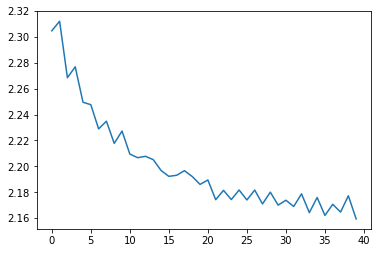

[ 6.79294438e-01  1.17860259e-02 -1.75521951e-02 -3.14010476e-01
  2.32579413e-01  4.66892947e-04  4.91324288e-01 -7.11651062e-01
 -3.31420889e-01 -4.08164347e-02]
0.9197315787108074


In [37]:
plt.plot(losses)
plt.show()
print(bias)
diff_thetas = thetas - init_thetas
print(np.sqrt(np.sum(diff_thetas*diff_thetas)))

In [181]:
etas = [1e-1]
start = time.time()
accuracies = []
losses = []
for epoch in range(1):
    for eta in etas:
        for i, data in enumerate(train_loader, 0):
            print(labels)
            inputs, labels = data
            X = encoder(inputs.view(len(labels), -1))
            dcost = qml.grad(cost, argnum=[2,3])
            theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias)
            loss = cost(X.numpy(), labels.numpy(), thetas, bias)
            losses.append(loss)
            thetas -= eta * theta_grad
            bias -= eta * bias_grad
            acc = accuracy(thetas, bias)
            accuracies.append(acc)
            print("%d batches took %f seconds and has accuracy %f, with train loss %f" % (i + 1, time.time() - start, acc, loss))
            if i == 20:
                break

tensor([3, 7, 8, 4, 6, 5, 9, 4, 8, 7, 8, 1, 0, 9, 3, 7])
[8, 6, 7, 6, 8, 8, 8, 6, 5, 6, 8, 8, 8, 8, 6, 6]
[8, 6, 8, 6, 6, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8]
1 batches took 16.688527 seconds and has accuracy 0.031250, with train loss 2.297098
tensor([2, 3, 1, 1, 8, 3, 1, 5, 4, 5, 1, 0, 2, 6, 7, 0])
[5, 6, 7, 6, 1, 5, 8, 6, 8, 6, 8, 8, 8, 8, 6, 1]
[5, 6, 5, 6, 6, 5, 8, 7, 5, 5, 8, 3, 8, 6, 8, 4]
2 batches took 33.328079 seconds and has accuracy 0.000000, with train loss 2.306482
tensor([7, 2, 2, 2, 5, 3, 5, 1, 0, 6, 4, 3, 5, 6, 4, 0])
[1, 6, 7, 7, 8, 8, 5, 1, 1, 6, 8, 8, 8, 5, 6, 8]
[8, 6, 6, 6, 6, 8, 5, 1, 5, 8, 8, 1, 7, 7, 8, 3]
3 batches took 49.407852 seconds and has accuracy 0.000000, with train loss 2.309803
tensor([2, 7, 9, 9, 1, 2, 1, 0, 8, 4, 5, 5, 2, 0, 1, 1])
[1, 6, 1, 7, 1, 7, 8, 1, 5, 6, 7, 8, 8, 5, 6, 2]
[5, 6, 1, 6, 2, 7, 8, 4, 8, 8, 7, 8, 1, 7, 8, 7]
4 batches took 65.276373 seconds and has accuracy 0.093750, with train loss 2.295561
tensor([4, 6, 0, 7, 2, 5, 9, 8, 9, 1, 7,

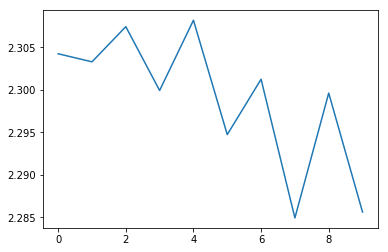

[ 0.08351886 -0.03586817 -0.00538317 -0.03651299 -0.03605283 -0.00593571
 -0.00632599  0.02434582  0.02424944 -0.00603525]
0.014775035931243952


In [18]:
plt.plot(losses)
plt.show()
print(bias)
diff_thetas = thetas - init_thetas
print(np.sqrt(np.sum(diff_thetas*diff_thetas)))

In [164]:
#Check for favoritism
for i in range(NUM_CLASSES):
    print(circuit_tighten(np.random.randn(ENCODING_SIZE), MASK, thetas[i]) + bias[i])

[-0.08729522 -0.03729522 -0.09329522 -0.04729522]
[-0.83772512  1.03827488 -0.79772512  1.03427488]
[ 0.91148296  0.59148296 -0.13851704  0.59148296]
[0.99986255 0.80186255 0.85586255 0.80586255]
[-0.97759454 -0.58759454  0.14840546 -0.58959454]
[-0.06805835  0.02194165 -0.06605835  0.01794165]
[ 0.8774088 -0.5485912  0.8374088 -0.5565912]
[0.98727886 0.26327886 0.22327886 0.26527886]
[-0.30220064 -0.23020064 -0.29620064 -0.22220064]
[0.25290899 0.97090899 0.33090899 0.97690899]
